In [1]:

import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Gerar dataset sintético com 20 variáveis
X, y = make_classification(n_samples=1000, n_features=20,
                           n_informative=5, n_redundant=5,
                           n_repeated=0, n_classes=2,
                           random_state=42)

df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(20)])
df['target'] = y

# 2. Dividir treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('target', axis=1), df['target'], test_size=0.3, random_state=42)

# 3. Treinar modelo base com todas as features
model_full = RandomForestClassifier(random_state=42)
model_full.fit(X_train, y_train)
y_pred_full = model_full.predict(X_test)
acc_full = accuracy_score(y_test, y_pred_full)




🎯 Acurácia com todas as 20 features: 0.9300


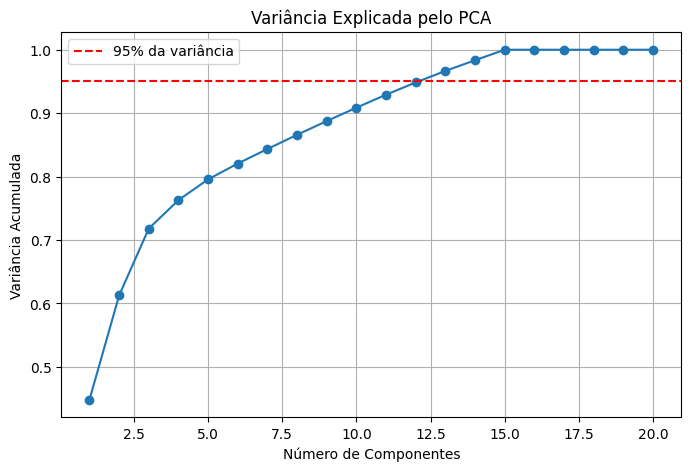

In [2]:
print(f"🎯 Acurácia com todas as 20 features: {acc_full:.4f}")

# 4. Analisar variância explicada com PCA
pca = PCA().fit(X_train)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Visualizar variância explicada
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Acumulada')
plt.title('Variância Explicada pelo PCA')
plt.grid()
plt.axhline(y=0.95, color='r', linestyle='--', label='95% da variância')
plt.legend()
plt.show()


In [3]:

# 5. Reduzir dimensionalidade mantendo 95% da variância
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"🔧 Número de componentes após PCA: {X_train_pca.shape[1]}")

# 6. Treinar modelo com dados reduzidos
model_pca = RandomForestClassifier(random_state=42)
model_pca.fit(X_train_pca, y_train)
y_pred_pca = model_pca.predict(X_test_pca)
acc_pca = accuracy_score(y_test, y_pred_pca)

print(f"✅ Acurácia após PCA: {acc_pca:.4f}")

🔧 Número de componentes após PCA: 13
✅ Acurácia após PCA: 0.9133


In [5]:
X_train.shape

(700, 20)

# Por que a acurácia pode não melhorar (ou até piorar) após PCA?

- PCA não leva o target em consideração
- PCA é uma técnica não supervisionada — ela busca maximizar a variância dos dados, não a separação entre as classes (target). Ou seja, ela pode descartar variáveis com baixa variância que são importantes para a predição.

*Exemplo: uma variável que distingue bem a classe pode ter pouca variância, e ainda assim ser essencial para o modelo preditivo. O PCA pode jogá-la fora.*


## 2. Transformação pode causar perda de interpretabilidade
Após PCA, os dados são transformados em componentes lineares, como PC1, PC2, etc., que não têm significado direto. Isso pode afetar a capacidade do modelo de capturar relações não lineares que estariam mais claras nos dados originais.

## O modelo original já estava performando bem
Se os dados originais já estavam bem preparados e não havia muito ruído ou multicolinearidade prejudicial, o PCA pode não trazer benefícios, e em alguns casos até remover sinais úteis.

## Random Forest lida bem com alta dimensionalidade
No seu exemplo, usamos o RandomForestClassifier, que gerencia bem dados com muitas features. Ele tem embutida uma forma de seleção de atributos (por meio dos splits nas árvores), então o ganho com PCA é geralmente pequeno.

# Quando PCA pode ajudar?
 - Quando o dataset tem muitas variáveis altamente correlacionadas

 - Quando há overfitting evidente com muitos atributos

 - Quando se utiliza algoritmos sensíveis à dimensionalidade, como:

  - k-NN

  - SVM

  - Regressão Logística

  - Para visualização (redução para 2D ou 3D)

In [6]:
from sklearn.feature_selection import SelectKBest, f_classif

# Selecionar as 10 melhores features com base na correlação com o target
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X_train, y_train)
X_test_new = selector.transform(X_test)

# Treinar modelo com as melhores features
model_selected = RandomForestClassifier(random_state=42)
model_selected.fit(X_new, y_train)
y_pred_selected = model_selected.predict(X_test_new)

print("🔍 Acurácia com SelectKBest:", accuracy_score(y_test, y_pred_selected))


🔍 Acurácia com SelectKBest: 0.9433333333333334


In [7]:
X_new.shape

(700, 10)